
- из данных убраны дубли

In [1]:
TRAIN_CSV = f"./datasets/train_clean.csv"
SMALL_CSV = f"./cache/train.csv"
SCORING_CSV = f"./datasets/test.csv"

USE_SMALL = True

max_title = 36          # max 103, 3 сигмы 34 + 2
max_abstract = 460      # max 1096, 3 сигмы 457 + 3

In [2]:
import torch
from tqdm import tqdm

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Датасеты

In [3]:
# !pip install datasets
import datasets

In [4]:
arxiv_dataset = datasets.Dataset.from_csv(SMALL_CSV if USE_SMALL else TRAIN_CSV)

Using custom data configuration default-04a3546adcf83ebb
Reusing dataset csv (/home/user1/.cache/huggingface/datasets/csv/default-04a3546adcf83ebb/0.0.0)


In [5]:
test_size = 0.2 if USE_SMALL else 0.02
arxiv_dataset = arxiv_dataset.train_test_split(test_size=test_size)
pass

In [6]:
len(arxiv_dataset["train"]), len(arxiv_dataset["test"]), arxiv_dataset["train"][0].keys()

(800, 200, dict_keys(['abstract', 'title']))

In [7]:
scoring_dataset = datasets.Dataset.from_csv(SCORING_CSV)
len(scoring_dataset), scoring_dataset[0].keys()

Using custom data configuration default-2e0a9ad90b647d2d
Reusing dataset csv (/home/user1/.cache/huggingface/datasets/csv/default-2e0a9ad90b647d2d/0.0.0)


(1000, dict_keys(['abstract']))

## Токенайзер

In [8]:
from transformers import AutoTokenizer

# google/bert_uncased_L-8_H-512_A-8     # medium
# tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-4_H-512_A-8")   # small
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-8_H-512_A-8")   # medium

In [9]:
tokenizer("some long long  long  long  long  long text", max_length=5, truncation=True)

{'input_ids': [101, 2070, 2146, 2146, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [10]:
prefix = "summarize: "

def preprocess_function(examples):
    """ Длины последовательностей max = 1096 / 103. Берем какбе 3 сигмы:
        - max_length=457 + 4
        - max_length=34 + 2
    """

    srcs = [prefix + doc for doc in examples["abstract"]]
    model_inputs = tokenizer(srcs, max_length=max_abstract, truncation=True) # max_length includes special tokens

    with tokenizer.as_target_tokenizer():
        trgs = tokenizer(examples["title"], max_length=max_title, truncation=True)

    model_inputs["labels"] = trgs["input_ids"]
    return model_inputs

In [11]:
tokenized_arxiv = arxiv_dataset.map(preprocess_function, batched=True)

100%|██████████| 1/1 [00:00<00:00, 11.67ba/s]


In [12]:
tokenized_arxiv["train"][0].keys(), tokenized_arxiv["train"][0]["abstract"], tokenized_arxiv["train"][0]["title"]

(dict_keys(['abstract', 'title', 'input_ids', 'token_type_ids', 'attention_mask', 'labels']),
 "we present in an unified and detailed way the nested bethe ansatz for closed spin chains based on y(gl(n)), y(gl(m|n)), u_q(gl(n)) or u_q(gl(m|n)) (super)algebras, with arbitrary representations (i.e. `spins') on each site of the chain. in particular, the case of indecomposable representations of superalgebras is studied. the construction extends and unifies the results already obtained for spin chains based on y(gl(n)) or u_q(gl(n)) and for some particular super-spin chains. we give the bethe equations and the form of the bethe vectors. the case of gl(2|1), gl(2|2$ and gl(4|4) superalgebras (that are related to ads/cft correspondence) is also detailed.",
 'nested bethe ansatz for "all" closed spin chains')

Итераторы

In [13]:
tokenized_arxiv['test'][0].keys()

dict_keys(['abstract', 'title', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [14]:
def collate_batch(batch, padding_value=tokenizer.pad_token_id):
   """Дополняем батч паддингом до размера максимального в батче""" 

   src_tuple_of_seqs = tuple(map(lambda x: torch.LongTensor(x["input_ids"]), batch))
   src_att_tuple_of_seqs = tuple(map(lambda x: torch.LongTensor(x["attention_mask"]), batch))
   trg_tuple_of_seqs = tuple(map(lambda x: torch.LongTensor(x["labels"]), batch))
   padded_sources = torch.nn.utils.rnn.pad_sequence(src_tuple_of_seqs, 
                                                    padding_value=padding_value, batch_first=True)
   padded_srs_atts = torch.nn.utils.rnn.pad_sequence(src_att_tuple_of_seqs, 
                                                    padding_value=padding_value, batch_first=True)
   padded_targets = torch.nn.utils.rnn.pad_sequence(trg_tuple_of_seqs, 
                                                    padding_value=padding_value, batch_first=True)
   return {"input_ids": padded_sources, 
           "attention_mask": padded_srs_atts,
           "labels": padded_targets}

def data_loader(dataset, batch_size, shuffle=True, **kwargs):
    return torch.utils.data.DataLoader(dataset=dataset, 
                                       batch_size=batch_size, 
                                       shuffle=shuffle, 
                                       collate_fn=collate_batch,
                                       num_workers=0,
                                       **kwargs)

next(iter(data_loader(tokenized_arxiv['test'], batch_size=2)))

{'input_ids': tensor([[  101,  7680,  7849,  4697,  1024,  1000, 21216,  1000,  4725,  2265,
           2307,  4872,  2005,  6022, 29494,  2358, 11663, 20875, 24710,  1997,
           3375, 16012, 15869,  4668,  6125,  1012,  2174,  1010,  2261,  6742,
           5097,  1997, 21216,  2031,  2596,  1999,  1996,  3906,  2000,  3058,
           1012,  2182,  1010,  2057,  4769,  2023,  3277,  2478,  1996,  1000,
          13571,  2098, 21216,  9896,  1000,  1006, 20228,  2050,  1007,  1031,
           1048,  1012,  1037,  1012,  5671,  1998,  1052,  1012, 24530,  1010,
           1046,  1012, 18178,  2213,  1012,  6887,  7274,  1012,  8732,  1010,
          14748, 10790,  2581,  1006,  2294,  1007,  1033,  1010,  1037,  3728,
           1011,  3107,  4800, 15782,  2571, 21216,  3921,  1012,  2057,  2224,
           1996, 20228,  2050,  2000,  8556,  2358, 11663, 20875,  3896,  1999,
           2048,  2944, 16012, 15869,  4668,  6125,  1012,  1996,  6125,  2008,
           2057,  5136,  20

# Модель

In [15]:
from transformers import EncoderDecoderModel

# google bert-small https://huggingface.co/google/bert_uncased_L-4_H-512_A-8
model = EncoderDecoderModel.from_encoder_decoder_pretrained('google/bert_uncased_L-8_H-512_A-8', 'google/bert_uncased_L-8_H-512_A-8') # medium
model.to(device)

Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing B

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_af

При обучении тагрет в модель подается кроме последнего токена, при валидации/генрации - кроме первого.

Поэтому для генерации сид-фраза должна начинаться с того токена, на котором модель обучалась, в данном случае это первый токен берта `[CLS]`

In [16]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

In [17]:
from helpers.utils import count_parameters

count_parameters(model)

+---------------------------------------------------------------------+-----+-------------+------------+---------------+----------+
|                           Modules/Tensors                           | GPU |    Shape    | Parameters |      Type     | DataMem  |
+---------------------------------------------------------------------+-----+-------------+------------+---------------+----------+
|              encoder.embeddings.word_embeddings.weight              |  +  | 30522 x 512 |  15627264  | torch.float32 | 62509056 |
|            encoder.embeddings.position_embeddings.weight            |  +  |  512 x 512  |   262144   | torch.float32 | 1048576  |
|           encoder.embeddings.token_type_embeddings.weight           |  +  |   2 x 512   |    1024    | torch.float32 |   4096   |
|                 encoder.embeddings.LayerNorm.weight                 |  +  |     512     |    512     | torch.float32 |   2048   |
|                  encoder.embeddings.LayerNorm.bias                  |  +  

91191098

In [18]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Обучение

In [19]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5)

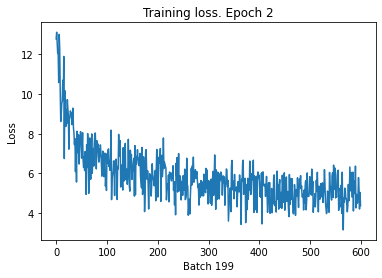

2


In [28]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

MODEL_NAME = "./models/bert2bert-medium.pt"
MODEL_PATH = "./bert2bert-base-results"
BATCH_SIZE = 4
ACCUMULATION_STEPS = 8

model.train()
train_loss_set = []
train_loss = 0
save_step = 500

train_ds = data_loader(tokenized_arxiv['train'], batch_size=BATCH_SIZE)
val_ds = data_loader(tokenized_arxiv['test'], batch_size=BATCH_SIZE)

for epoch in range(3):
    for step, batch in enumerate(train_ds):
        model.zero_grad()
        outputs = model(input_ids=batch["input_ids"].to(device), # маски (по-идее) само сделает
                        labels=batch["labels"].to(device))
        
        loss, logits = outputs.loss, outputs.logits
        train_loss_set.append(loss.item())
        
        loss.backward()
        if (step + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        
        train_loss += loss.item()

        clear_output(True)
        #plt.cla()
        plt.plot(train_loss_set)
        plt.title(f"Training loss. Epoch {epoch}")
        plt.xlabel(f"Batch {step}")
        plt.ylabel("Loss")
        plt.show()
        if step != 0 and step % save_step == 0:
            model.save_pretrained("bert2bert")
            torch.save(model.state_dict(), MODEL_NAME)

    print(epoch)

В общем вроде сходится

# Генерация

In [29]:
def generate(example):
    input_ids = tokenizer(prefix + example["abstract"], 
                        max_length=max_abstract, 
                        truncation=True, 
                        return_tensors="pt").input_ids  # Batch size 1
    outputs = model.generate(input_ids.to(device))
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [30]:
n = 10
arxiv_dataset["test"][n]["abstract"], arxiv_dataset["test"][n]["title"], generate(arxiv_dataset["test"][n])

('in most illiquid markets, there is no obvious proxy for the market price of an asset. the european corporate bond market is an archetypal example of such an illiquid market where mid-prices can only be estimated with a statistical model. in this otc market, dealers / market makers only have access, indeed, to partial information about the market. in real time, they know the price associated with their trades on the dealer-to-dealer (d2d) and dealer-to-client (d2c) markets, they know the result of the requests for quotes (rfq) they answered, and they have access to composite prices (e.g., bloomberg cbbt). this paper presents a bayesian method for estimating the mid-price of corporate bonds by using the real-time information available to a dealer. this method relies on recent ideas coming from the particle filtering / sequential monte-carlo literature.',
 'mid-price estimation for european corporate bonds: a particle filtering   approach',
 'of of - - - - - - - - - - - - - - - -')

In [ ]:
n = 42
arxiv_dataset["test"][n]["abstract"], arxiv_dataset["test"][n]["title"], generate(arxiv_dataset["test"][n])

# BLEU-score

Самоделки:
- 0.02457 (словарь 6152, по 5 эпох по 5r-4, 1e-3, min.val.loss = 3.875) 
- **0.19204** (словарь 60 тыс. ~15 эпох с шагом 5e-4 -> 5e-5, min.val.loss = 2.289)
- 0.12601 (словарь 84 тыс. много разных эпох, сходится плохо, min.val.loss = 3.305)
- 0.10644 (BPE, словарь 16 тыс., много разных эпох, сходится плохо, min.val.loss = 3.8)

T5-small
- BLEU-score: **0.044...** 1% тюнинг
- BLEU-score: **0.16563** (3 эпохи - 2,5 часа RTX2060 6Gb)

T5-base
- BLEU-score: **0.07422** (без обучения)
- обучение не тянет...

BART-base
- BLEU-score: **0.17743** 1% тюнинг
- BLEU-score: **0.17984** (1.43 эпохи - 2,5 часа RTX2060 6Gb)
- BLEU-score: **0.19266** (2 эпохи)

bert2bert-small (4 слоя, 8 голов внимания, 512 эмбеддинг)
- BLEU-score: **0.00524** 1% тюнинг
- BLEU-score: **0.04807** (2 эпохи) чето не то....
 

In [ ]:
from torchtext.data.metrics import bleu_score

tqdm._instances.clear()

candidates = []
references = []
for example in tqdm(tokenized_arxiv["test"]):
    candidates.append(generate(example).split())
    references.append([example["title"].split()])

score = bleu_score(candidates, references, max_n=3, weights=[1/3]*3)

print('BLEU-score: {0:.5f}'.format(score))

### Stepik score

In [ ]:
SUBMISSION_NAME = "bert2bert-small" if USE_SMALL else "bert2bert-small-tune"

Генерация заголовков для тестовых данных

In [ ]:
tqdm._instances.clear()

abstracts = []
titles = []

for example in tqdm(scoring_dataset):
    abstracts.append(example["abstract"])
    titles.append(generate(example))

Получилось, например

In [ ]:
abstracts[1], titles[1]

Записываем полученные заголовки в файл формата `<abstract>,<title>`:

In [ ]:
import pandas as pd

submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv(f"./submission/predicted_titles_{SUBMISSION_NAME}.csv", index=False)

In [ ]:
submission_df["title"].apply(lambda x: len(str(x).split())).describe()[["mean","std", "max"]]

С помощью скрипта `generate_csv` приводим файл `submission_prediction.csv` в формат, необходимый для отправки:

In [ ]:
from helpers.create_submission import generate_csv

generate_csv(input_file=f"./submission/predicted_titles_{SUBMISSION_NAME}.csv", 
             output_file=f'./submission/submission_{SUBMISSION_NAME}.csv', 
             voc_file=f'./datasets/vocs.pkl')

# С учетом

In [ ]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("./datasets/train.csv")
submission_df = pd.read_csv(f"./submission/predicted_titles_{SUBMISSION_NAME}.csv")

intersect_idx = np.intersect1d(submission_df["abstract"].str.lower(), train_df["abstract"].str.lower(), return_indices=True)

submission_df.loc[intersect_idx[1], 'title'] = train_df.loc[intersect_idx[2], 'title'].values

In [ ]:
from helpers.create_submission import generate_csv

submission_df.to_csv(f"./submission/predicted_titles_{SUBMISSION_NAME}_fake.csv", index=False)

generate_csv(input_file=f"./submission/predicted_titles_{SUBMISSION_NAME}_fake.csv", 
             output_file=f'./submission/submission_{SUBMISSION_NAME}_fake.csv', 
             voc_file=f'./datasets/vocs.pkl')

In [ ]:
f'./submission/submission_{SUBMISSION_NAME}_fake.csv'

T5-small:
- **Score: 0.26174** 1% tuning
- **Score: 0.34497** tuning 3 эпохи
- **Score: 0.51810** + добавление правильных меток из трейна

T5-base:
- **Score: 0.20510** w/o tuning
- для обучения с имеющейся длиной последовательности не хватает памяти GPU

BART-base
- **Score: 0.33851** 1% tuning
- **Score: 0.39536** tuning 1,5 эпохи
- **Score: 0.54804** + добавление правильных меток из трейна
- **Score: 0.56782** 2 эпохи с накопление градиента (вот и в топ-10)
- ... дальше не интересно